In [ ]:
!pip install tensorflow==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0
    Uninstalling te

In [ ]:
!pip install tensorflow-privacy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 15.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.12.0 which is incompatible.


In [ ]:
# !pip install imblearn

In [ ]:
import os
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
     auc,
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from sklearn.model_selection import StratifiedKFold



#Filtering errors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Preprocess Data

In [ ]:
data  = pd.read_csv('/content/drive/MyDrive/BotNeTIoT-L01_label_NoDuplicates.csv', index_col = 0)

In [ ]:

# Binary problem
target_column = 'label'
display(data[target_column].unique())
num_classes = data[target_column].nunique()

array([0, 1])

In [ ]:
# Identify non-numeric columns (there are none)
print(data.select_dtypes(include='object').columns)

Index([], dtype='object')


In [ ]:
categorical_columns = [col for col in data.columns if col not in [target_column]] # Other columns

X = data.drop(target_column, axis=1)
y = data[target_column]

# Split into training test and validation datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)



# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

## PATE Default MLP

In [ ]:
num_classes = data[target_column].nunique()
# mlp_model = Sequential()
# Define teacher model architecture
def create_teacher_model(input_shape, num_classes):
    model = Sequential([
        Dense(288, activation="relu", input_shape=input_shape),
        Dropout(0.2),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model

# Define student model architecture
def create_student_model(input_shape, num_classes):
    model = Sequential([
        Dense(288, activation="relu", input_shape=input_shape),
        Dropout(0.2),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model
# # Add the first dense layer with dropout
# mlp_model.add(Dense(32, activation='relu', input_shape=(len(categorical_columns),)))
# mlp_model.add(Dropout(0.5))

# # Add the second dense layer with dropout
# mlp_model.add(Dense(32, activation='relu'))
# mlp_model.add(Dropout(0.5))

# Define hyperparameters
num_teachers = 1
input_shape = (len(categorical_columns),)
epsilon = 1.0
kfolds = 2
epoch_num = 2

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)  # Set random_state for reproducibility
cv_results = []

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Create and train teacher models for this fold
    teacher_models = []
    for i in range(num_teachers):
        teacher_model = create_teacher_model(input_shape, num_classes)
        teacher_model.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])
        teacher_model.fit(X_train_fold, y_train_fold, epochs=epoch_num, batch_size=32)  # Adjust epochs and batch_size as needed
        teacher_models.append(teacher_model)

    # Generate labels for the training data using teacher models
    def generate_labels(data):
        labels = []
        for model in teacher_models:
            labels.append(np.argmax(model.predict(data), axis = 1))
        return labels

    # Define your student model
    student_model = create_student_model(input_shape, num_classes)
    student_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

    # Generate labels for the training data using teacher models
    train_labels = generate_labels(X_train_fold)
    student_y_train_fold = pd.Series(train_labels[0], index = y_train_fold.index)

    # Train the student model using the labels generated by the teacher models
    student_model.fit(X_train_fold, student_y_train_fold, epochs=epoch_num, batch_size=32)  # Adjust epochs and batch_size as needed

    # Evaluate the student model on the validation set
    val_loss, val_accuracy = student_model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit the full model on the entire training set
teacher_models = []
for i in range(num_teachers):
    teacher_model = create_teacher_model(input_shape, num_classes)
    teacher_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
    teacher_model.fit(X_train_scaled[categorical_columns], y_train, epochs=epoch_num, batch_size=32)  # Adjust epochs and batch_size as needed
    teacher_models.append(teacher_model)

# Generate labels for the training data using teacher models
def generate_labels(data):
    labels = []
    for model in teacher_models:
        labels.append(np.argmax(model.predict(data), axis = 1))
    return labels

# Define your student model
student_model = create_student_model(input_shape, num_classes)
student_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Generate labels for the training data using teacher models
train_labels = generate_labels(X_train_scaled[categorical_columns])
student_train_labels = pd.Series(train_labels[0], index = X_train_scaled.index)

# Train the student model using the labels generated by the teacher models
model_history =  student_model.fit(X_train_scaled[categorical_columns], student_train_labels, epochs=epoch_num, batch_size=32, validation_split = 0.2)  # Adjust epochs and batch_size as needed

# Evaluate the student model on the test set
test_loss, test_accuracy = student_model.evaluate(X_test_scaled[categorical_columns], y_test)

# Predict on the test data
y_test_pred_mlp = student_model.predict(X_test_scaled[categorical_columns])

# Convert probability predictions to class labels
y_test_pred_classes_mlp = np.argmax(y_test_pred_mlp, axis=1)

Epoch 1/2
28437/28437 [==============================] - 176s 6ms/step - loss: 0.0065 - accuracy: 0.9988
Epoch 2/2
28437/28437 [==============================] - 66s 2ms/step
Epoch 1/2
28437/28437 [==============================] - 188s 7ms/step - loss: 0.0036 - accuracy: 0.9993
Epoch 2/2
28437/28437 [==============================] - 74s 3ms/step - loss: 0.0168 - accuracy: 0.9993
Epoch 1/2
28437/28437 [==============================] - 181s 6ms/step - loss: 0.0070 - accuracy: 0.9987
Epoch 2/2
28437/28437 [==============================] - 67s 2ms/step
Epoch 1/2
28437/28437 [==============================] - 187s 7ms/step - loss: 0.0048 - accuracy: 0.9992
Epoch 2/2
28437/28437 [==============================] - 81s 3ms/step - loss: 0.0687 - accuracy: 0.9994
Epoch 1/2
56873/56873 [==============================] - 367s 6ms/step - loss: 0.0077 - accuracy: 0.9990
Epoch 2/2
56873/56873 [==============================] - 140s 2ms/step
Epoch 1/2
45499/45499 [==============================] -

In [ ]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp = accuracy_score(y_test, y_test_pred_classes_mlp)
precision_mlp = precision_score(y_test, y_test_pred_classes_mlp, average='macro')
recall_mlp = recall_score(y_test, y_test_pred_classes_mlp, average='macro')
f1_mlp = f1_score(y_test, y_test_pred_classes_mlp, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp}")
print(f"Precision = {precision_mlp}")
print(f"Recall = {recall_mlp}")
print(f"F1 Score =  {f1_mlp}")

Average cross-validation loss: 0.04273143783211708
Average cross-validation accuracy: 0.9993510842323303
MLP Model:
Accuracy =  0.9992458521870287
Precision = 0.9987298186108625
Recall = 0.9990076288243985
F1 Score =  0.998868646333795


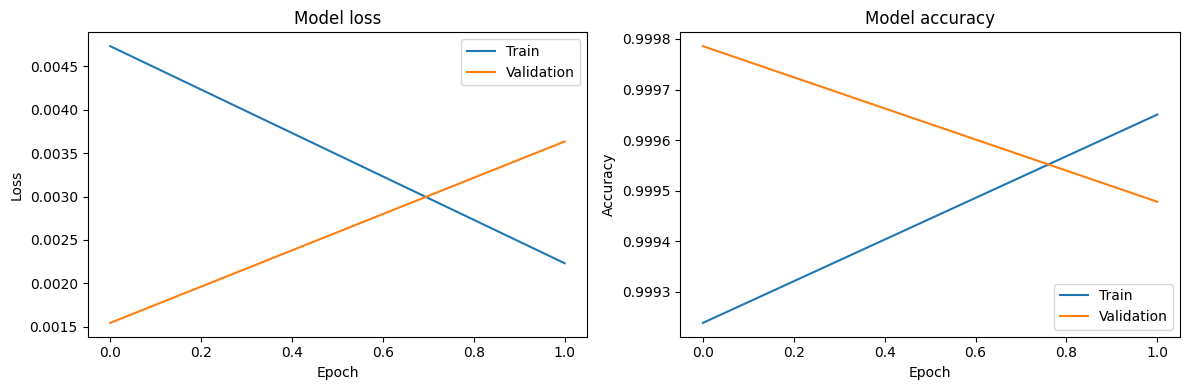

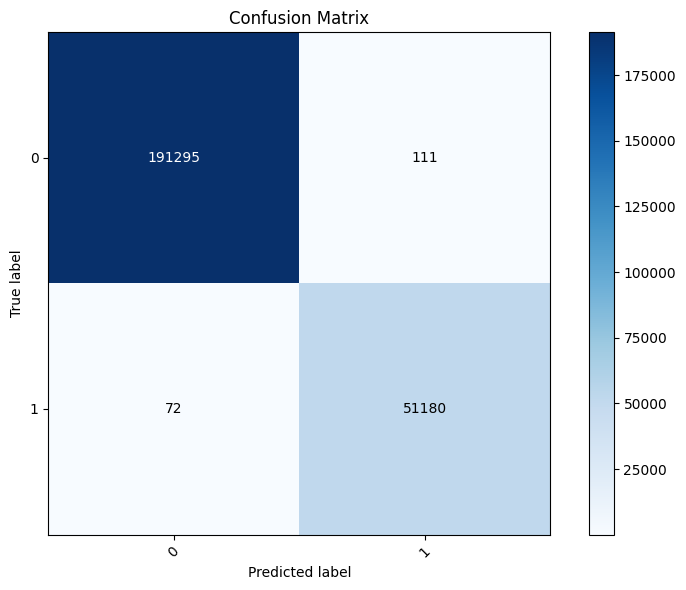

In [ ]:
# Function to plot loss curves
def plot_loss(history1, history2=None):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values for the first model
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values for the first model
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    if history2 is not None:
        # Plot training & validation loss values for the second model
        plt.subplot(1, 2, 1)
        plt.plot(history2.history['loss'], linestyle='dashed')
        plt.plot(history2.history['val_loss'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='upper right')

        # Plot training & validation accuracy values for the second model
        plt.subplot(1, 2, 2)
        plt.plot(history2.history['accuracy'], linestyle='dashed')
        plt.plot(history2.history['val_accuracy'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot loss curves
plot_loss(model_history)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes_mlp)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = [0, 1]

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Precision-Recall Curve (Not possible for Multiclass Classification, it is designed for Binary Class only)
# precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_mlp)
# area_under_curve = auc(recall, precision)

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {area_under_curve:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

## PATE Privacy

In [ ]:
# Define your teacher model architecture
def create_teacher_model(input_shape, num_classes):
    model = Sequential([
        Dense(288, activation="relu", input_shape=input_shape),
        Dropout(0.2),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model

# Define differential privacy parameters
batch_size = 16
l2_norm_clip = 1.0
noise_multiplier = 1.3
num_microbatches = 1

# Create a DP optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=0.003
)

# Define your student model architecture with differential privacy
def create_student_model_privacy(input_shape, num_classes):
    model = Sequential([
        Dense(288, activation="relu", input_shape=input_shape),
        Dropout(0.2),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(288, activation="relu"),
        Dense(64, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax"),
        Dense(num_classes, activation="softmax")  # Add an additional layer for differential privacy
    ])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Define hyperparameters
num_teachers = 1
input_shape = (len(categorical_columns),)
epsilon = 1.0
kfolds = 2
epoch_num = 2

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)  # Set random_state for reproducibility
cv_results = []

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Create and train teacher models for this fold
    teacher_models = []
    for i in range(num_teachers):
        teacher_model = create_teacher_model(input_shape, num_classes)
        teacher_model.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])
        teacher_model.fit(X_train_fold, y_train_fold, epochs=epoch_num, batch_size=32)  # Adjust epochs and batch_size as needed
        teacher_models.append(teacher_model)

    # Generate labels for the training data using teacher models
    def generate_labels(data):
        labels = []
        for model in teacher_models:
            labels.append(np.argmax(model.predict(data), axis = 1))
        return labels

    # Define your student model
    student_model_privacy = create_student_model_privacy(input_shape, num_classes)
    student_model_privacy.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

    # Generate labels for the training data using teacher models
    train_labels = generate_labels(X_train_fold)
    student_y_train_fold = pd.Series(train_labels[0], index = y_train_fold.index)

    # Train the student model using the labels generated by the teacher models
    student_model_privacy.fit(X_train_fold, student_y_train_fold, epochs=epoch_num, batch_size=32)  # Adjust epochs and batch_size as needed

    # Evaluate the student model on the validation set
    val_loss, val_accuracy = student_model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit the full model on the entire training set
teacher_models = []
for i in range(num_teachers):
    teacher_model = create_teacher_model(input_shape, num_classes)
    teacher_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
    teacher_model.fit(X_train_scaled[categorical_columns], y_train, epochs=epoch_num, batch_size=32)  # Adjust epochs and batch_size as needed
    teacher_models.append(teacher_model)

# Generate labels for the training data using teacher models
def generate_labels(data):
    labels = []
    for model in teacher_models:
        labels.append(np.argmax(model.predict(data), axis = 1))
    return labels

# Define your student model
student_model_privacy = create_student_model_privacy(input_shape, num_classes)
student_model_privacy.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Generate labels for the training data using teacher models
train_labels = generate_labels(X_train_scaled[categorical_columns])
student_train_labels = pd.Series(train_labels[0], index = X_train_scaled.index)

# Train the student model using the labels generated by the teacher models
model_history_privacy =  student_model_privacy.fit(X_train_scaled[categorical_columns], student_train_labels, epochs=epoch_num, batch_size=32, validation_split = 0.2)  # Adjust epochs and batch_size as needed

# Evaluate the student model on the test set
test_loss, test_accuracy = student_model_privacy.evaluate(X_test_scaled[categorical_columns], y_test)


Epoch 1/2
28437/28437 [==============================] - 205s 7ms/step - loss: 0.0073 - accuracy: 0.9988
Epoch 2/2
28437/28437 [==============================] - 70s 2ms/step
Epoch 1/2
28437/28437 [==============================] - 183s 6ms/step - loss: 0.4887 - accuracy: 0.8028
Epoch 2/2
28437/28437 [==============================] - 74s 3ms/step - loss: 0.0067 - accuracy: 0.9992
Epoch 1/2
28437/28437 [==============================] - 179s 6ms/step - loss: 0.0070 - accuracy: 0.9988
Epoch 2/2
28437/28437 [==============================] - 68s 2ms/step
Epoch 1/2
28437/28437 [==============================] - 188s 7ms/step - loss: 0.1742 - accuracy: 0.9346
Epoch 2/2
28437/28437 [==============================] - 75s 3ms/step - loss: 0.0063 - accuracy: 0.9992
Epoch 1/2
56873/56873 [==============================] - 355s 6ms/step - loss: 0.0074 - accuracy: 0.9990
Epoch 2/2
56873/56873 [==============================] - 134s 2ms/step
Epoch 1/2
45499/45499 [==============================] -

In [ ]:
# Predict on the test data
y_test_pred_mlp_privacy = student_model_privacy.predict(X_test_scaled[categorical_columns])

# # Apply the threshold to make binary predictions
y_test_pred_binary_mlp_privacy = y_test_pred_mlp_privacy.argmax(axis=1)

7584/7584 [==============================] - 19s 2ms/step


In [ ]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp_privacy = accuracy_score(y_test, y_test_pred_binary_mlp_privacy)
precision_mlp_privacy = precision_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
recall_mlp_privacy = recall_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
f1_mlp_privacy = f1_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp_privacy}")
print(f"Precision = {precision_mlp_privacy}")
print(f"Recall = {recall_mlp_privacy}")
print(f"F1 Score =  {f1_mlp_privacy}")

Average cross-validation loss: 0.006513941800221801
Average cross-validation accuracy: 0.9992175698280334
MLP Model:
Accuracy =  0.9945149139941811
Precision = 0.9898690337028728
Recall = 0.9937657186430392
F1 Score =  0.9918017909799823


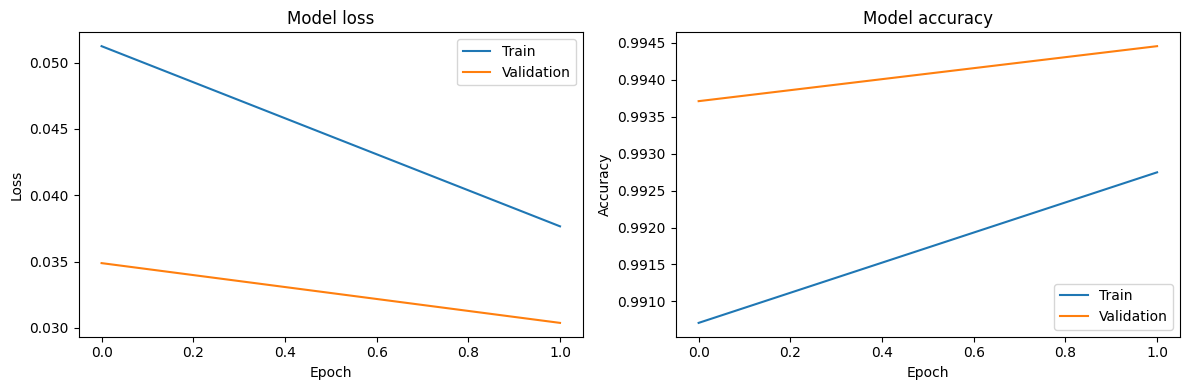

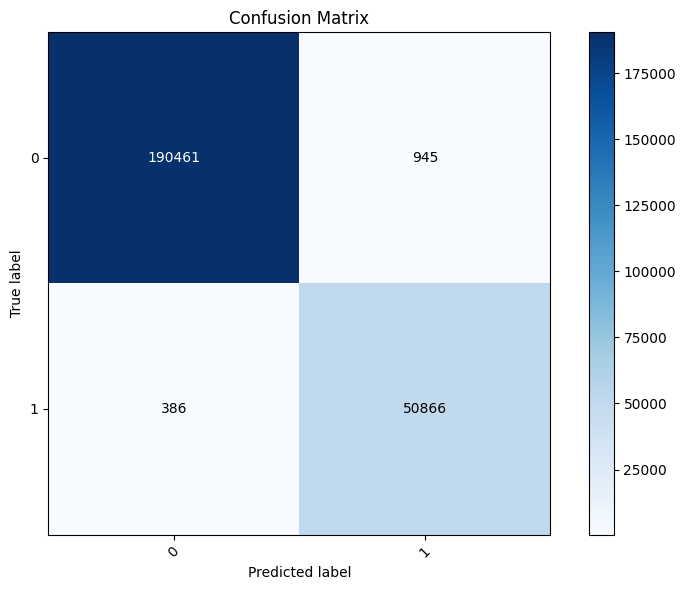

In [ ]:
# Plot loss curves
plot_loss(model_history_privacy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary_mlp_privacy)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = [0,1]

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Precision-Recall Curve
# precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_binary_mlp_privacy)
# area_under_curve = auc(recall, precision)

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label=f'Privacy Model Precision-Recall Curve (AUC = {area_under_curve:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Privacy Model Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

In [ ]:
# Extract trainable variables from the model
trainable_variables = student_model_privacy.trainable_variables

# Compute privacy budget
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_scaled),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    num_epochs=30,
    delta=1e-5
)

In [ ]:
print(privacy_report)

DP-SGD performed over 1819930 examples with 16 examples per iteration, noise
multiplier 1.3 for 30 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        74.229
    Epsilon assuming Poisson sampling (*):                      1.035

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.



## Combine

In [ ]:
# Create DataFrame
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Regular': [accuracy_mlp, precision_mlp, recall_mlp, f1_mlp],
    'Privacy': [accuracy_mlp_privacy, precision_mlp_privacy, recall_mlp_privacy, f1_mlp_privacy]
}

df = pd.DataFrame(data)

# Print DataFrame
display(df)

,Metric,Regular,Privacy
0,Accuracy,0.999246,0.994515
1,Precision,0.998730,0.989869
2,Recall,0.999008,0.993766
3,F1 Score,0.998869,0.991802


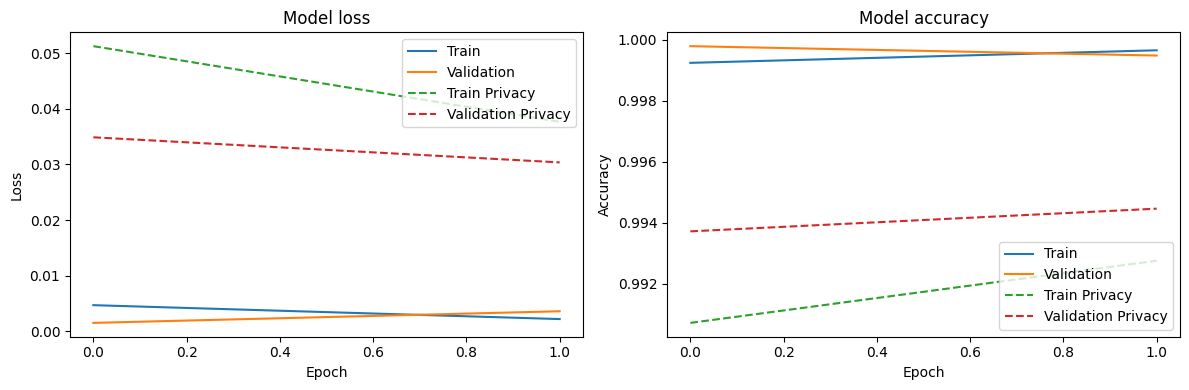

In [ ]:
plot_loss(model_history, model_history_privacy)